tgb - 1/8/2020 - Figures 1 and 2 for my birthday to prepare our MPI project for submission. Heavily based on Julia's notebooks:    
Figure 1 = [https://github.com/tbeucler/2019_WMI/blob/master/dev/jwindmiller/Bistability_Fig1.ipynb]  
Figure 1 long-time average for ERA = [https://github.com/tbeucler/2019_WMI/blob/master/dev/jwindmiller/Seasonal_cycle.ipynb]  
Figure 1 PDF for COSMO = [https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/014_Unified_Figures_1_and_2.ipynb]
Figure 2 = [https://github.com/tbeucler/2019_WMI/blob/master/dev/jwindmiller/Potential_LFE_Fig2.ipynb]

# 0) Initialization

## 0.1) Imports

In [99]:
# Initial imports
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

In [2]:
# Figure characteristics common to all Figures
fz = 15
lw = 3
siz = 10

plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

# Physical constants
stday = 24*3600

In [97]:
col1 = np.array([255,126,14])/255
col2 = np.array([43,160,43])/255
col3 = np.array([31,119,179])/255

col_A = ['C0', 'C1', 'C2']

## 0.2) Utilities

In [3]:
class Bunch(object):
  
    def __init__(self, adict):
        self.__dict__.update(adict)

In [4]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [5]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [86]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind

# 1) Figure 1

## 1.1) COSMO simulations (Fig 1a and 1c)

### 1.1.1) Figure 1a = Final (aggregated) state of column water vapor

#### Make Figure

In [6]:
path_RCE = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [7]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [8]:
RCE300

<xarray.Dataset>
Dimensions:       (bnds: 2, level1: 75, rlat: 506, rlon: 506, soil1: 10, srlat: 506, srlon: 506, time: 2400)
Coordinates:
  * rlon          (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat          (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * srlon         (srlon) float32 0.015 0.044999998 ... 15.135 15.165
  * srlat         (srlat) float32 0.015 0.044999998 ... 15.135 15.165
    lon           (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat           (rlat, rlon) float32 -2.504478e-06 ... 15.149999
    height_2m     float32 2.0
    height_toa    float32 33250.0
  * soil1         (soil1) float32 0.005 0.025 0.07 0.16 ... 1.47 2.86 5.74 11.5
  * time          (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-10-20T11:00:00
Dimensions without coordinates: bnds, level1
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(2400, 2), chunksize=(1, 2)>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b''

In [9]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

In [10]:
CWV_agg = RCE300.TQV[(24*ENDstart):].mean(dim='time')

In [11]:
CWV_agg

<xarray.DataArray 'TQV' (rlat: 506, rlon: 506)>
dask.array<shape=(506, 506), dtype=float32, chunksize=(506, 506)>
Coordinates:
  * rlon        (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat        (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
    lon         (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat         (rlat, rlon) float32 -2.504478e-06 -2.5044778e-06 ... 15.149999
    height_2m   float32 2.0
    height_toa  float32 33250.0

In [12]:
toplot = CWV_agg.values

In [13]:
dx = 3.3
x = dx*CWV_agg.rlon
y = dx*CWV_agg.rlat

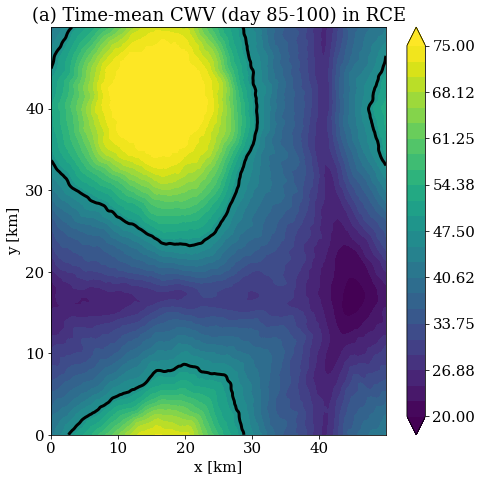

In [14]:
fig,ax = plt.subplots(figsize=(7.5,7.5))


ax.contour(x,y, toplot,[48.00],colors='k')
cont_levels = np.linspace(20,75,25)
im = ax.contourf(x, y, toplot, cont_levels, vmin = 20, vmax = 75, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Time-mean CWV (day 85-100) in RCE')
cbar = plt.colorbar(im)

#### Save reduced data

#### Make Figure from reduced data

### 1.1.2) Figure 1c = PDF of column water vapor

In [165]:
# Load reduced data into dictionary S
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
path = pathPKL+'2019_11_19_Fig1a.pkl'
hf = open(path,'rb')
S = pickle.load(hf)

In [166]:
F1c = Bunch(S)

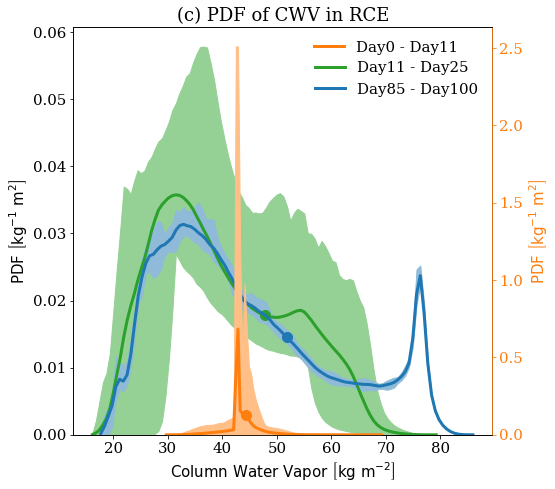

In [167]:
fig,ax = plt.subplots(figsize=(7.5,7.5))

# Figure 1a
ax2 = ax.twinx()

# Shading goes in the back
ax2.fill_between(edgTObin(F1c.SPINedges),F1c.SPIN_min,F1c.SPIN_max,color=1-(1-F1c.SPINrgb)/2)
ax.fill_between(edgTObin(F1c.COALedges),F1c.COAL_min,F1c.COAL_max,color=1-(1-F1c.COALrgb)/2)
ax.fill_between(edgTObin(F1c.COARedges),F1c.COAR_min,F1c.COAR_max,color=1-(1-F1c.COARrgb)/2)

# Right axis = Day 11-100
SPINline = ax2.plot(edgTObin(F1c.SPINedges),F1c.CWV_PDF_SPIN,color=F1c.SPINrgb,label='Day0 - Day11')
# Add dots to indicate mean value of percentile chosen for MMLi
ax2.scatter(x=F1c.SPIN_P48_mean,y=np.interp(x=F1c.SPIN_P48_mean,xp=edgTObin(F1c.SPINedges),fp=F1c.CWV_PDF_SPIN),color=F1c.SPINrgb)

ax2.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$',color=F1c.SPINrgb)
ax2.spines['right'].set_color(F1c.SPINrgb)
ax2.tick_params(axis='y', colors=F1c.SPINrgb)
ax2.set_ylim((0,ax2.get_ylim()[1]))
leg2 = ax2.legend(frameon=False,bbox_to_anchor=(0,0,0.95,1))

# Left axis = Day0-Day11
COALline = ax.plot(edgTObin(F1c.COALedges),F1c.CWV_PDF_COAL,color=F1c.COALrgb,label='Day11 - Day25')
COARline = ax.plot(edgTObin(F1c.COARedges),F1c.CWV_PDF_COAR,color=F1c.COARrgb,label='Day85 - Day100')
# Add dots to indicate mean value of percentile chosen for MMLi
ax.scatter(x=F1c.COAL_P48_mean,y=np.interp(x=F1c.COAL_P48_mean,xp=edgTObin(F1c.COALedges),fp=F1c.CWV_PDF_COAL),color=F1c.COALrgb)
ax.scatter(x=F1c.COAR_P48_mean,y=np.interp(x=F1c.COAR_P48_mean,xp=edgTObin(F1c.COARedges),fp=F1c.CWV_PDF_COAR),color=F1c.COARrgb)

leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(c) PDF of CWV in RCE')

plt.draw()

# Save figure
path_home = '/users/tbeucler/'
plt.savefig(path_home+'Fig1.pdf',format='pdf')

## 1.2) ERA5 Reanalysis

### 1.2.1) Figure 1b = Time-mean column water vapor field

#### Make Figure

In [168]:
path_ERA = '/project/s916/ERA5_Tom/'

In [169]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

In [170]:
date1, date2 = np.datetime64('2000-01-01T00:00'), np.datetime64('2017-12-31T23:00')

In [171]:
thresh = 83 #48mm in percentile

In [172]:
PW = xr.open_mfdataset(path_ERA+'????/??PW.nc',combine='by_coords')
PWAtl = PW['tcwv'].sel({'time':slice(date1, date2), 'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [ ]:
PWAtl_mean = PWAtl.mean('time').values

In [ ]:
time_A = PWAtl.time.values

In [ ]:
LSM = xr.open_mfdataset(path+'ERA_LANDSEAMASK.nc')
LSMAtl = LSM['lsm'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})

In [ ]:
# Calculate Area of domain assuming a rectangle (since we assumed constant dx for the contour)
dx = 110/4 #km
A_domain = PWAtl.shape[1]*PWAtl.shape[2]*(dx**2) #km**2
L_band = 2.0*PWAtl.shape[2]*dx
circle_sw = False

In [ ]:
year = 2009
YEAR = np.arange(2000,2018)# np.append(np.arange(2000,2014), np.arange(2015,2018)) #2014 is missing!

In [ ]:
# Multi-year mean of CWV 
fig, axes = plt.subplots(1,1,figsize=(7.5,7.5))

print(axes)

tmp = PWAtl_mean

axes.contour(lonAtl, latAtl, tmp, [48.00], colors=['k'])#, vmin = 2.7e9, vmax=2.85e9)
cont_levels = np.linspace(20,55,25)
im = axes.contourf(lonAtl, latAtl, tmp, cont_levels, vmin = 20, vmax = 55, extend='both')
# for c in im.collections:
#     c.set_edgecolor("face")
# axes.set_aspect('equal')

locs = axes.get_xticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    labels[i_l] = '%iW'%int(360-loc)
axes.set_xticklabels(labels) 

locs = axes.get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
axes.set_yticklabels(labels)
axes.set_title('(b) Time-mean CWV (2000-2017) in ERA5')

cbar = plt.colorbar(im)

#### Save reduced data

#### Make Figure from reduced data

### 1.2.2) Figure 1d = PDF of column water vapor for ERA

#### Make Figure

In [154]:
nbins = 30
xbins = np.linspace(10, 70, 31)

In [155]:
path_JuliaPKL = '/users/tbeucler/2019_WMI/dev/jwindmiller/PKL_DATA/'
dic_hist = np.load(path_JuliaPKL+'CWV_hist_%i_%i_%i_%i_%i.npz'%(nbins, latmin, latmax, lonmin, lonmax))

hist_total = dic_hist['hist_total']
bin_edges = dic_hist['bin_edges']

In [156]:
hist_cum = np.cumsum(hist_total)/np.sum(hist_total)

In [157]:
hist_total = hist_total/np.sum(hist_total)/(bin_edges[1]-bin_edges[0])

In [158]:
with open(path_JuliaPKL+'pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

Modify times_A so that times_A[1] coincides with the minimum in contour length

In [84]:
#times_A[1] = np.datetime64('2005-12-02T17:00:00.000000000')

Plot Figure

In [161]:
switch_kde = False
method = 'KDE' if switch_kde else 'PDF'

2005-11-23T14:00:00.000000000 51.01881408691406
1.0000000000000002
2005-12-04T14:00:00.000000000 50.59869644165037
0.9999999999999999
2005-12-07T14:00:00.000000000 43.8817024230957
0.9999999999999999


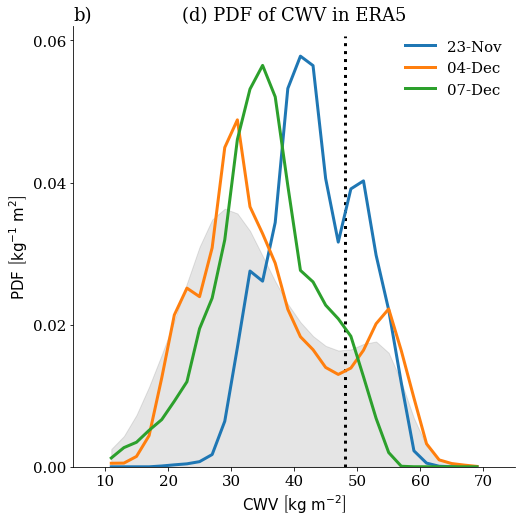

In [164]:
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))

x = np.linspace(10,75,161)



for i, time in enumerate(times_A):

    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    #tmp = np.squeeze(PWAtl.sel({'time':time}).values) 
    
    print(time, np.percentile(tmp, thresh))
    
    if switch_kde:
        density = stats.gaussian_kde(np.ndarray.flatten(tmp))
        plt.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"), color = col_A[i])
    else:
        hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = xbins)
        plt.plot(edgTObin(edges), hist, label = pd.to_datetime(time).strftime("%d-%b"), color = col_A[i])
        print(np.sum(hist*(edges[1:]-edges[:-1])))
    
    plt.legend(frameon=False)
    #plt.vlines([np.percentile(tmp, per_thresh_era5)], 0.0, ymax, linestyle=':', color = 'C%i'%i)
    
#plt.plot(bin_centers, hist_total, 'k')
plt.fill_between(edgTObin(edges),hist_total, color = 'k',label='85d-100d', alpha = 0.1)
    
ymin, ymax = plt.ylim()
plt.vlines([48], 0.0, ymax, linestyle=':')
plt.ylim(0.0, 0.062)
plt.yticks([0.0, 0.02, 0.04, 0.06])
plt.xlim(xbins[0]-5, xbins[-1]+5)

ax.set_xlabel(r'$\mathrm{CWV}$ $\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method)
ax.set_title('(d) PDF of CWV in ERA5')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('b)', loc = 'left')
    
plt.tight_layout()

#plt.savefig('./Figures/Fig1b.pdf', bbox_inches = "tight")

#### Save Reduced Data

#### Make Figure from reduced data

## 1.3) Combine all subplots into single Figure

# 2) Figure 2

## 2.1) COSMO simulations

## 2.2) ERA5 Reanalysis

### Make Figure

In [33]:
CONJUL_data = {}

path_PKL = '/users/tbeucler/2019_WMI/dev/jwindmiller/PKL_DATA/'

for i,year in enumerate(range(2000,2018)):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, thresh)+str(year)+'.pkl','rb') # open('../jwindmiller/PKL_DATA/10_17_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CONJUL_data[year] = tmp['Tot_Contour_km'][str(year)]
    
cont_t = np.array(get_all_values(CONJUL_data))

In [142]:
with open(path_PKL+'pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

Find minimal contour between times_A[0] and times_A[2]

In [35]:
date1, date2 = np.datetime64('2005-01-01T00:00'), np.datetime64('2005-12-31T23:00')

In [36]:
time_period = time_A[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]

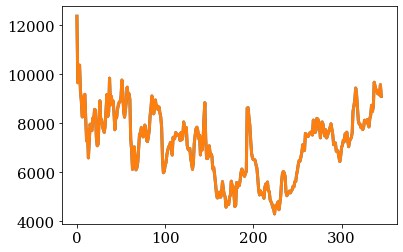

In [66]:
plt.plot(CONJUL_data[2005][7833:8179])
plt.plot(cont_t[((366+365+365+365+366)*24+7833):((366+365+365+365+366)*24+8179)])

In [70]:
it_min = np.argmin(cont_period)

In [71]:
it_min

224

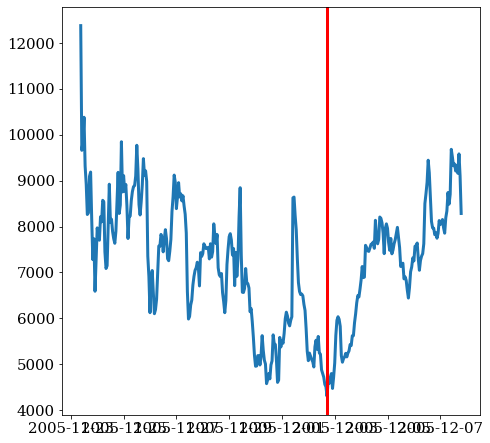

In [75]:
plt.figure(figsize=(7.5,7.5))
plt.plot(time_period,cont_period)
plt.axvline(x=time_period[it_min],color='r')

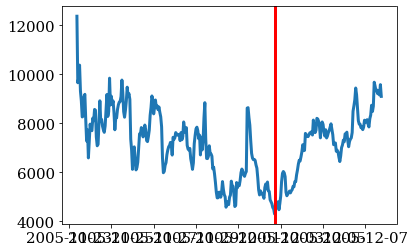

In [79]:
itA_min = (366+365+365+365+366)*24+7833+it_min
plt.plot(time_A[((366+365+365+365+366)*24+7833):((366+365+365+365+366)*24+8179)],cont_t[((366+365+365+365+366)*24+7833):((366+365+365+365+366)*24+8179)])
plt.axvline(x=time_A[itA_min],color='r')

In [80]:
time_A[itA_min]

numpy.datetime64('2005-12-02T17:00:00.000000000')

Modify times_A[1] accordingly

In [128]:
times_A[1] = time_A[itA_min]

Calculate PW tendency, Potential, LFE

In [143]:
times_Vstart = times_A[0] 
times_Vend   = times_A[1] 

ileftV = find_index(time_A, np.datetime64(times_Vstart))
irightV = find_index(time_A, np.datetime64(times_Vend))

In [144]:
PWAtl_res = PWAtl[ileftV-1:irightV+2,:,:].values # If can't fit in the memory, can't calculate potential

In [145]:
dt = 3600
dPW_dt = (PWAtl_res[2:,:,:]-PWAtl_res[:-2,:,:])/(2*dt)

In [146]:
tmp,binm_Vfinal,Vfinal = Landau.Landau_energy(PWAtl_res[1:-1,:,:],dPW_dt,N_bins=50)

In [147]:
date_startF = times_A[0] 
date_endF   = times_A[-1]

ileftF = find_index(time_A, np.datetime64(date_startF))
irightF = find_index(time_A, np.datetime64(date_endF))
PWAtl_F = PWAtl[ileftF:irightF,:,:]
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(PWAtl_F.values,N_bins=30,V_fixed=Vfinal,bin_fixed=binm_Vfinal)

In [148]:
dbin_Vfinal = (binm_Vfinal[1:]-binm_Vfinal[:-1])[0]
binc_Vfinal = binm_Vfinal-0.5*dbin_Vfinal
binc_Vfinal = np.append(binc_Vfinal, binc_Vfinal[-1]+dbin_Vfinal)

In [149]:
dic_hist = {}
times_labels = pd.to_datetime(times_A).strftime("%d-%b")
times_year   = int(pd.to_datetime(times_A[0]).strftime("%Y"))

for i, time in enumerate(times_A):
    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(6,'h'), time+np.timedelta64(6,'h'))}).values)
    hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = binc_Vfinal)
    
    dic_hist[times_labels[i]]=hist
    
dic_hist.keys()

dict_keys(['23-Nov', '04-Dec', '07-Dec'])

2005-11-23T02:00:00.000000000 2005-11-24T02:00:00.000000000
12
2005-12-04T02:00:00.000000000 2005-12-05T02:00:00.000000000
13
2005-12-07T02:00:00.000000000 2005-12-08T02:00:00.000000000
12


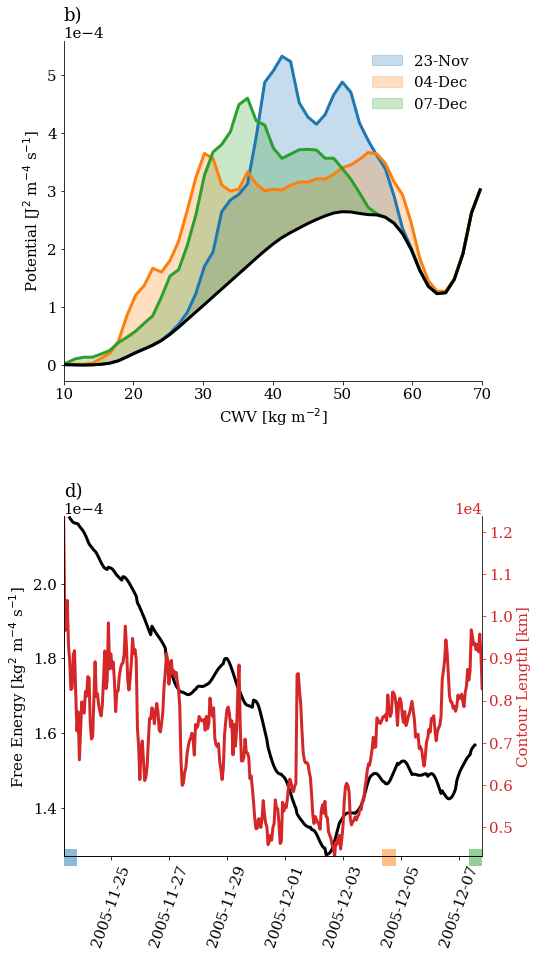

In [152]:
option = 'Agg' # Aggregating, potential averaged from imin_left to imax
option = 'Dis' # Disaggregating, potential averaged from imax to imin_right

plt.close('all')
fig,ax = plt.subplots(2,1,figsize=(7.5,15))
plt.subplots_adjust(hspace=0.33)


ax[0].set_title('b)',pad=20, loc = 'left')
ax[0].set_xlabel(r'CWV [kg m$^{-2}$]')
ax[0].set_ylabel(r'Potential [J$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].set_xlim(10,70)

for i, time_lab in enumerate(times_labels):
    ax[0].fill_between(binm_Vfinal, Vfinal, Vfinal+dic_hist[time_lab]*5e-3,color=col_A[i],label=time_lab, alpha = 0.25)
    ax[0].plot(binm_Vfinal, Vfinal+dic_hist[time_lab]*5e-3,color=col_A[i])
    
ax[0].plot(binm_Vfinal, Vfinal,color='k')

ax[0].legend(frameon=False)

time_period = time_A[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]
cont_period = cont_t[np.where((time_A>times_A[0]-np.timedelta64(6,'h'))&(time_A<times_A[-1]+np.timedelta64(6,'h')))]

axbis = ax[1].twinx()
axbis.plot(time_period, cont_period,color='C3')
#axbis.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C3:')
axbis.spines['right'].set_color('C3')
axbis.tick_params(axis='y', colors='C3')

axbis.set_ylabel('Contour Length [km]',color='C3')

ax[0].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

ax[0].spines['right'].set_visible(False)
axbis.spines['right'].set_visible(False)

ax[1].plot(PWAtl_F.time, Ffinal,color='k')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )


ymin_C, ymax_C = 4.301e3, 1.2377e4
axbis.set_ylim(ymin_C, ymax_C)

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
period_y_max, period_y_min = -0.03, 0.02

for i, time in enumerate(times_A):

    print(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))
    ax[1].fill_between(x=time_period,y1=period_y_min,y2=period_y_max,where=(time_period<=(time+np.timedelta64(6,'h')))&(time_period>=(time-np.timedelta64(6,'h'))),
                       facecolor=col_A[i],alpha=0.5,transform=trans, clip_on = False)
    
    print(len(np.where(((time_period>=(time-np.timedelta64(6,'h')))&(time_period<=(time+np.timedelta64(6,'h')))))[0]))

ax[1].set_xlim((time_period.min(),time_period.max()))
#ymin_F, ymax_F = 3.5e-4, 5.2e-4 #ax[1].get_ylim() # For aggregation on Dec2
ymin_F, ymax_F = 1.27e-4, 2.18e-4 #ax[1].get_ylim() # For aggregation on Dec4
ax[1].set_ylim((ymin_F, ymax_F))
ax[1].set_title('d)',loc='left', pad = 20)
ax[1].set_ylabel(r'Free Energy [kg$^{2}$ m$^{-4}$ s$^{-1}$]')

ax[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
ax[1].ticklabel_format(style='sci',scilimits=(-3,4),axis='y')
axbis.ticklabel_format(style='sci',scilimits=(-3,4),axis='y')

plt.subplots_adjust(hspace = 0.4)

ax[1].spines['top'].set_visible(False)
axbis.spines['top'].set_visible(False)

In [137]:
Ffinal.min()

0.0003686879078201546

In [138]:
Ffinal.max()

0.0005153938672284994

In [139]:
cont_period.max()

12376.954364826302

In [140]:
cont_period.min()

4301.39087296526

### Save reduced data

### Make Figure from reduced data